# NYC Taxi Fare Prediction

## Setup

In [306]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_palette('muted')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import folium
from string import ascii_uppercase

In [ ]:
# taxi = pd.read_csv('train_prev.csv')        # Truncated preview
taxi = pd.read_csv('train.csv', nrows=5000000)

## Inspection

In [307]:
taxi.head(20)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1
8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.993078,40.731628,1
9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2


In [308]:
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.000000e+06,5.000000e+06,5.000000e+06,4.999964e+06,4.999964e+06,5.000000e+06
mean,1.134080e+01,-7.250678e+01,3.991974e+01,-7.250652e+01,3.991725e+01,1.684695e+00
std,9.820175e+00,1.280970e+01,8.963509e+00,1.284777e+01,9.486767e+00,1.331854e+00
min,-1.000000e+02,-3.426609e+03,-3.488080e+03,-3.412653e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399206e+01,4.073491e+01,-7.399139e+01,4.073404e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076711e+01,-7.396367e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,3.310364e+03,3.457622e+03,3.345917e+03,2.080000e+02


In [309]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   key                object 
 1   fare_amount        float64
 2   pickup_datetime    object 
 3   pickup_longitude   float64
 4   pickup_latitude    float64
 5   dropoff_longitude  float64
 6   dropoff_latitude   float64
 7   passenger_count    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 305.2+ MB


## Cleaning

### Pickup Datetime

In [310]:
taxi['pickup_datetime'] = pd.to_datetime(taxi['pickup_datetime'])
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 8 columns):
 #   Column             Dtype              
---  ------             -----              
 0   key                object             
 1   fare_amount        float64            
 2   pickup_datetime    datetime64[ns, UTC]
 3   pickup_longitude   float64            
 4   pickup_latitude    float64            
 5   dropoff_longitude  float64            
 6   dropoff_latitude   float64            
 7   passenger_count    int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 305.2+ MB


### NaN Values

In [311]:
taxi.dropna(subset=['dropoff_longitude', 'dropoff_latitude'], inplace=True)
taxi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4999964 entries, 0 to 4999999
Data columns (total 8 columns):
 #   Column             Dtype              
---  ------             -----              
 0   key                object             
 1   fare_amount        float64            
 2   pickup_datetime    datetime64[ns, UTC]
 3   pickup_longitude   float64            
 4   pickup_latitude    float64            
 5   dropoff_longitude  float64            
 6   dropoff_latitude   float64            
 7   passenger_count    int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 343.3+ MB


### Fare Amount

<Axes: xlabel='fare_amount'>

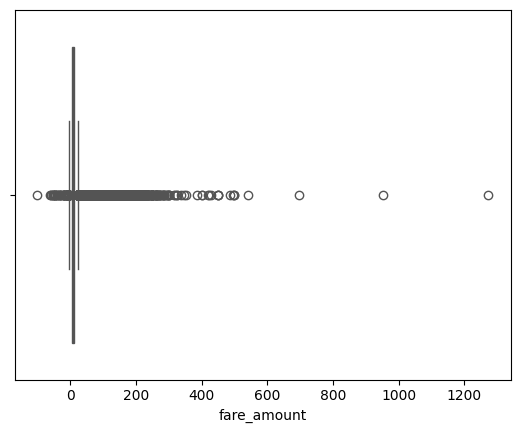

In [312]:
sns.boxplot(data=taxi, x='fare_amount')

In [313]:
# len(taxi.loc[~taxi['fare_amount'].between(0, 200)])
taxi = taxi.loc[taxi['fare_amount'].between(0, 200)]
taxi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4999588 entries, 0 to 4999999
Data columns (total 8 columns):
 #   Column             Dtype              
---  ------             -----              
 0   key                object             
 1   fare_amount        float64            
 2   pickup_datetime    datetime64[ns, UTC]
 3   pickup_longitude   float64            
 4   pickup_latitude    float64            
 5   dropoff_longitude  float64            
 6   dropoff_latitude   float64            
 7   passenger_count    int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 343.3+ MB


### Pickup Longitude

<Axes: xlabel='pickup_longitude'>

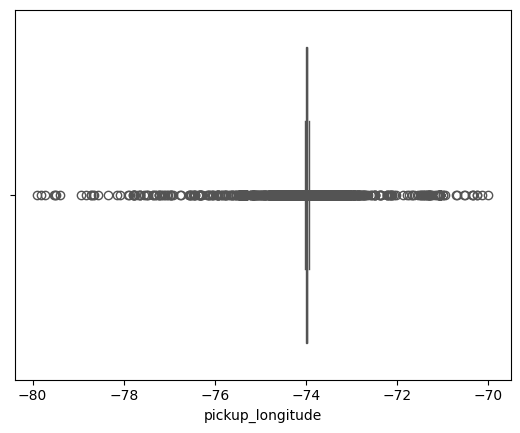

In [314]:
sns.boxplot(data=taxi.loc[taxi['pickup_longitude'].between(-80, -70)], x='pickup_longitude')

In [315]:
# len(taxi.loc[~taxi['pickup_longitude'].between(-74.5, -73.2)])
taxi = taxi.loc[taxi['pickup_longitude'].between(-74.5, -73.2)]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,4.898323e+06,4.898323e+06,4.898323e+06,4.898323e+06,4.898323e+06,4.898323e+06
mean,1.131926e+01,-7.397543e+01,4.075401e+01,-7.391116e+01,4.071794e+01,1.684641e+00
std,9.618998e+00,3.527059e-02,2.360271e+00,3.352910e+00,3.939061e+00,1.315705e+00
min,0.000000e+00,-7.449650e+01,0.000000e+00,-2.125745e+03,-3.114339e+03,0.000000e+00
25%,6.000000e+00,-7.399227e+01,4.073654e+01,-7.399157e+01,4.073551e+01,1.000000e+00
50%,8.500000e+00,-7.398210e+01,4.075334e+01,-7.398059e+01,4.075382e+01,1.000000e+00
75%,1.250000e+01,-7.396834e+01,4.076752e+01,-7.396529e+01,4.076839e+01,2.000000e+00
max,2.000000e+02,-7.320258e+01,2.977031e+03,1.328726e+03,3.210337e+03,2.080000e+02


### Pickup Latitude

<Axes: xlabel='pickup_latitude'>

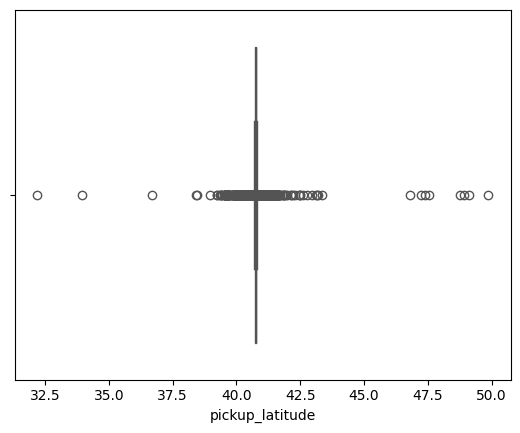

In [316]:
sns.boxplot(data=taxi.loc[taxi['pickup_latitude'].between(30, 50)], x='pickup_latitude')

In [317]:
# len(taxi.loc[~taxi['pickup_latitude'].between(40, 41.5)])
taxi = taxi.loc[taxi['pickup_latitude'].between(40, 41.5)]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,4.897606e+06,4.897606e+06,4.897606e+06,4.897606e+06,4.897606e+06,4.897606e+06
mean,1.131951e+01,-7.397543e+01,4.075084e+01,-7.391125e+01,4.071647e+01,1.684659e+00
std,9.619255e+00,3.524533e-02,2.742378e-02,3.351997e+00,3.535030e+00,1.315724e+00
min,0.000000e+00,-7.449650e+01,4.001813e+01,-2.125745e+03,-3.114339e+03,0.000000e+00
25%,6.000000e+00,-7.399228e+01,4.073654e+01,-7.399157e+01,4.073551e+01,1.000000e+00
50%,8.500000e+00,-7.398210e+01,4.075334e+01,-7.398059e+01,4.075382e+01,1.000000e+00
75%,1.250000e+01,-7.396835e+01,4.076752e+01,-7.396529e+01,4.076839e+01,2.000000e+00
max,2.000000e+02,-7.320258e+01,4.149911e+01,1.328726e+03,3.210337e+03,2.080000e+02


### Dropoff Longitude

<Axes: xlabel='dropoff_longitude'>

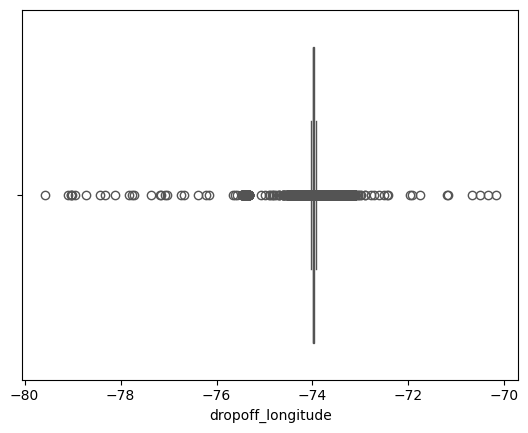

In [318]:
sns.boxplot(data=taxi.loc[taxi['dropoff_longitude'].between(-80, -70)], x='dropoff_longitude')

In [319]:
# len(taxi.loc[~taxi['dropoff_longitude'].between(-74.5, -73.2)])
taxi = taxi.loc[taxi['dropoff_longitude'].between(-74.5, -73.2)]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,4.892540e+06,4.892540e+06,4.892540e+06,4.892540e+06,4.892540e+06,4.892540e+06
mean,1.131409e+01,-7.397544e+01,4.075084e+01,-7.397453e+01,4.075124e+01,1.684706e+00
std,9.598850e+00,3.518840e-02,2.739857e-02,3.501018e-02,1.424313e+00,1.315697e+00
min,0.000000e+00,-7.449650e+01,4.001813e+01,-7.449994e+01,-2.518947e+03,0.000000e+00
25%,6.000000e+00,-7.399228e+01,4.073655e+01,-7.399158e+01,4.073559e+01,1.000000e+00
50%,8.500000e+00,-7.398210e+01,4.075334e+01,-7.398062e+01,4.075385e+01,1.000000e+00
75%,1.250000e+01,-7.396835e+01,4.076752e+01,-7.396538e+01,4.076839e+01,2.000000e+00
max,2.000000e+02,-7.320258e+01,4.149911e+01,-7.320000e+01,4.946500e+02,2.080000e+02


### Dropoff Latitude

<Axes: xlabel='dropoff_latitude'>

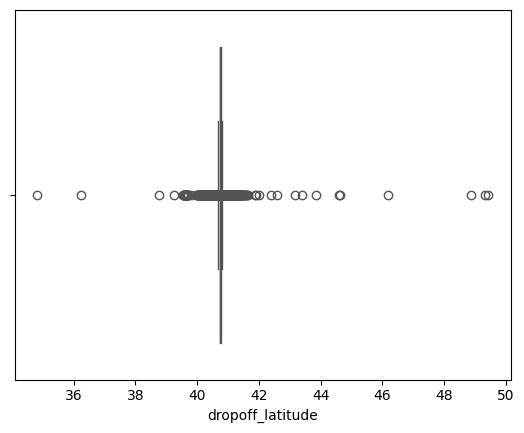

In [320]:
sns.boxplot(data=taxi.loc[taxi['dropoff_latitude'].between(30, 50)], x='dropoff_latitude')

In [321]:
# len(taxi.loc[~taxi['dropoff_latitude'].between(40, 41.5)])
taxi = taxi.loc[taxi['dropoff_latitude'].between(40, 41.5)]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,4.892066e+06,4.892066e+06,4.892066e+06,4.892066e+06,4.892066e+06,4.892066e+06
mean,1.131419e+01,-7.397544e+01,4.075084e+01,-7.397453e+01,4.075126e+01,1.684713e+00
std,9.599086e+00,3.518805e-02,2.739059e-02,3.500705e-02,3.128619e-02,1.315710e+00
min,0.000000e+00,-7.449650e+01,4.003383e+01,-7.449994e+01,4.000565e+01,0.000000e+00
25%,6.000000e+00,-7.399228e+01,4.073655e+01,-7.399158e+01,4.073559e+01,1.000000e+00
50%,8.500000e+00,-7.398210e+01,4.075334e+01,-7.398062e+01,4.075385e+01,1.000000e+00
75%,1.250000e+01,-7.396835e+01,4.076752e+01,-7.396538e+01,4.076840e+01,2.000000e+00
max,2.000000e+02,-7.320258e+01,4.149911e+01,-7.320000e+01,4.148991e+01,2.080000e+02


### Exact Same Pickup and Dropoff

In [322]:
taxi = taxi.loc[~((taxi['pickup_longitude'] == taxi['dropoff_longitude']) | (taxi['pickup_latitude'] == taxi['dropoff_latitude']))]

In [323]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4839210 entries, 0 to 4999999
Data columns (total 8 columns):
 #   Column             Dtype              
---  ------             -----              
 0   key                object             
 1   fare_amount        float64            
 2   pickup_datetime    datetime64[ns, UTC]
 3   pickup_longitude   float64            
 4   pickup_latitude    float64            
 5   dropoff_longitude  float64            
 6   dropoff_latitude   float64            
 7   passenger_count    int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 332.3+ MB


### Passenger Count

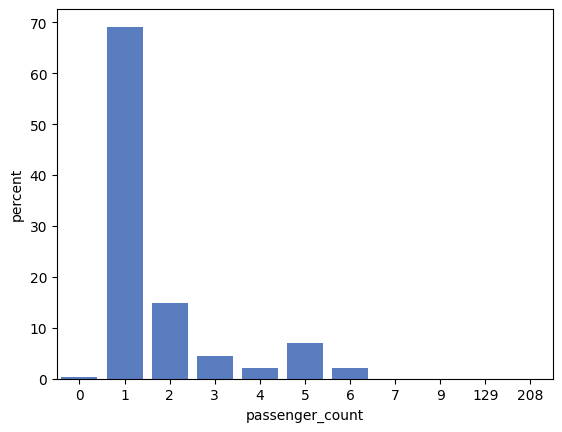

In [324]:
passenger_plt = sns.countplot(data=taxi, x='passenger_count', stat='percent')

In [325]:
# len(taxi.loc[taxi['passenger_count'] == 0])
taxi = taxi.loc[taxi['passenger_count'] != 0]
taxi.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,4.822103e+06,4.822103e+06,4.822103e+06,4.822103e+06,4.822103e+06,4.822103e+06
mean,1.132195e+01,-7.397559e+01,4.075088e+01,-7.397467e+01,4.075130e+01,1.690858e+00
std,9.536615e+00,3.473124e-02,2.716854e-02,3.455264e-02,3.113598e-02,1.314267e+00
min,0.000000e+00,-7.449450e+01,4.006092e+01,-7.449994e+01,4.000565e+01,1.000000e+00
25%,6.000000e+00,-7.399228e+01,4.073657e+01,-7.399159e+01,4.073562e+01,1.000000e+00
50%,8.500000e+00,-7.398213e+01,4.075336e+01,-7.398064e+01,4.075388e+01,1.000000e+00
75%,1.250000e+01,-7.396849e+01,4.076753e+01,-7.396555e+01,4.076841e+01,2.000000e+00
max,2.000000e+02,-7.320632e+01,4.149911e+01,-7.320000e+01,4.148991e+01,2.080000e+02


###

In [326]:
taxi.reset_index(drop=True, inplace=True)

In [327]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4822103 entries, 0 to 4822102
Data columns (total 8 columns):
 #   Column             Dtype              
---  ------             -----              
 0   key                object             
 1   fare_amount        float64            
 2   pickup_datetime    datetime64[ns, UTC]
 3   pickup_longitude   float64            
 4   pickup_latitude    float64            
 5   dropoff_longitude  float64            
 6   dropoff_latitude   float64            
 7   passenger_count    int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 294.3+ MB


## Feature Engineering

### Distance

In [328]:
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    km = 6371 * c
    return km

def distance_km(df):
    return haversine(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])

taxi['distance_km'] = distance_km(taxi)

### Time

In [329]:
def hour(df):
    return df['pickup_datetime'].dt.hour
def dayofweek(df):
    dow =  df['pickup_datetime'].dt.dayofweek
    return dow.replace({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun', })
def month(df):
    return df['pickup_datetime'].dt.month
def year(df):
    return df['pickup_datetime'].dt.year
def nighttime(df):
    return (df['hour'] >= 20) | (df['hour'] <= 5)

taxi['hour'] = hour(taxi)
taxi['dayofweek'] = dayofweek(taxi)
taxi['month'] = month(taxi)
taxi['year'] = year(taxi)
taxi['nighttime'] = nighttime(taxi)

### Passengers

In [330]:
def multiple_passengers(df):
    return np.where(df['passenger_count'] > 1, True, False)

taxi['multiple_passengers'] = multiple_passengers(taxi)

### Location

In [331]:
n_clusters = 16
n_init = 4
kmeans_pickup_loc = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=1)
kmeans_dropoff_loc = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=1)
kmeans_distance_loc = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=1)

def cluster(model, features, fit):
    if fit: model.fit(features)
    clust_name_dict = {i:f'cluster_{c}' for i,c in enumerate(ascii_uppercase)}
    return pd.Series(model.predict(features)).replace(clust_name_dict)

def pickup_loc(df, fit=False):
    return cluster(kmeans_pickup_loc, df[['pickup_longitude', 'pickup_latitude']], fit=fit)
def dropoff_loc(df, fit=False):
    return cluster(kmeans_dropoff_loc, df[['dropoff_longitude', 'dropoff_latitude']], fit=fit)
def distance_loc(df, fit=False):
    return cluster(kmeans_distance_loc, df[['distance_km', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']], fit=fit)

taxi['pickup_loc'] = pickup_loc(taxi, fit=True)
taxi['dropoff_loc'] = dropoff_loc(taxi, fit=True)
taxi['distance_loc'] = distance_loc(taxi, fit=True)

In [332]:
# sns.scatterplot(data=taxi, x='pickup_longitude', y='pickup_latitude', hue='pickup_loc', alpha=0.2)
# plt.legend(loc='upper right', bbox_to_anchor=(1.28, 1))
# plt.show(); plt.clf()

# sns.scatterplot(data=taxi, x='dropoff_longitude', y='dropoff_latitude', hue='dropoff_loc', alpha=0.2)
# plt.legend(loc='upper right', bbox_to_anchor=(1.28, 1))

### Airports

In [333]:
def jfk(df):
    return (df['pickup_longitude'].between(-73.7841, -73.7721) & df['pickup_latitude'].between(40.6213, 40.6613)) | (df['dropoff_longitude'].between(-73.7841, -73.7721) & df['dropoff_latitude'].between(40.6213, 40.6613))
def lga(df):
    return (df['pickup_longitude'].between(-73.8870, -73.8580) & df['pickup_latitude'].between(40.7680, 40.7800)) | (df['dropoff_longitude'].between(-73.8870, -73.8580) & df['dropoff_latitude'].between(40.7680, 40.7800))
def ewr(df):
    return (df['pickup_longitude'].between(-74.1920, -74.1720) & df['pickup_latitude'].between(40.6760, 40.7080)) | (df['dropoff_longitude'].between(-74.1920, -74.1720) & df['dropoff_latitude'].between(40.6760, 40.7080))

taxi['jfk'] = jfk(taxi)
taxi['lga'] = lga(taxi)
taxi['ewr'] = ewr(taxi)

In [334]:
m = folium.Map(location=(40.7, -74.0))
folium.Marker(location=(40.642, -73.779), icon=folium.Icon(icon='plane', prefix='fa')).add_to(m)
folium.Marker(location=(40.776, -73.874), icon=folium.Icon(icon='plane', prefix='fa')).add_to(m)
folium.Marker(location=(40.691, -74.178), icon=folium.Icon(icon='plane', prefix='fa')).add_to(m)
# taxi.loc[taxi['jfk_pu']].apply(lambda r:folium.Marker(location=(r['pickup_latitude'], r['pickup_longitude'])).add_to(m), axis=1)

display(m)

### Direction

In [335]:
def bearing(lat1, lon1, lat2, lon2):
    dlon = lon2 - lon1
    
    x = np.cos(np.radians(lat2)) * np.sin(np.radians(dlon))
    y = np.cos(np.radians(lat1)) * np.sin(np.radians(lat2)) - np.sin(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.cos(np.radians(dlon))
    bearing_rad = np.arctan2(x, y)
    
    bearing_deg = np.degrees(bearing_rad)
    return bearing_deg

def direction(df):
    return round(bearing(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude']))

taxi['direction'] = direction(taxi)

In [259]:
# m = folium.Map(location=(40.7, -74.0))
# row = 2
# folium.Marker(location=(taxi.iloc[row]['pickup_latitude'], taxi.iloc[row]['pickup_longitude']), icon=folium.Icon(icon='p', prefix='fa')).add_to(m)
# folium.Marker(location=(taxi.iloc[row]['dropoff_latitude'], taxi.iloc[row]['dropoff_longitude']), icon=folium.Icon(icon='d', prefix='fa')).add_to(m)
# display(m)

# print(taxi.iloc[row]['direction'])

## Relationships

### Fare vs Distance

<Axes: xlabel='distance_km', ylabel='fare_amount'>

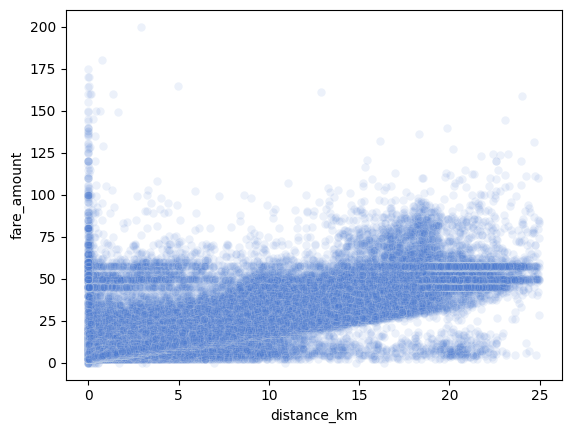

In [234]:
sns.scatterplot(data=taxi.loc[taxi['distance_km'] <= 25], x='distance_km', y='fare_amount', alpha=0.1)

In [235]:
# sns.lmplot(data=taxi.loc[taxi['distance_km'] <= 25], x='distance_km', y='fare_amount', hue='passenger_count', scatter_kws={'alpha':0.1})

### Fare vs Passengers

<Axes: xlabel='passenger_count', ylabel='count'>

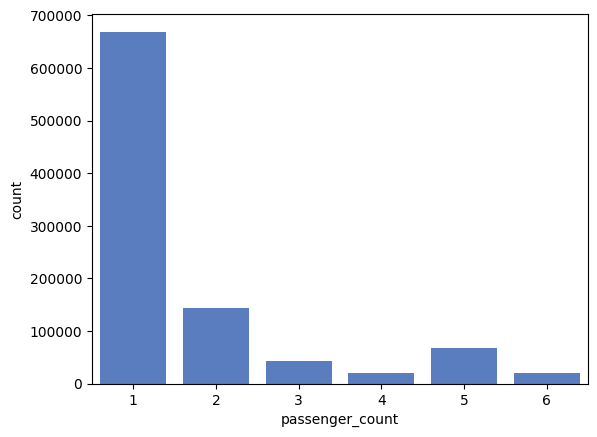

In [236]:
sns.countplot(data=taxi, x='passenger_count')

<Axes: xlabel='passenger_count', ylabel='fare_amount'>

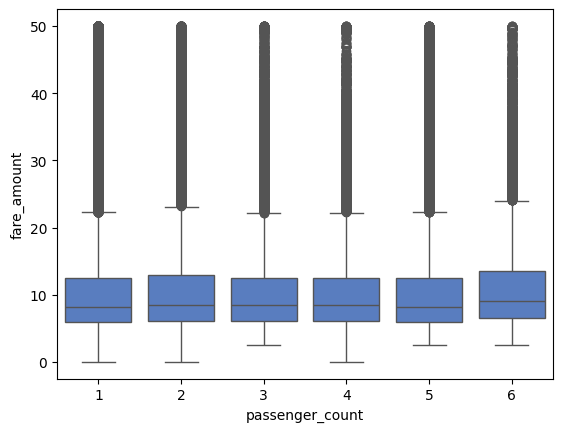

In [237]:
sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 50], x='passenger_count', y='fare_amount')

<Axes: xlabel='multiple_passengers', ylabel='fare_amount'>

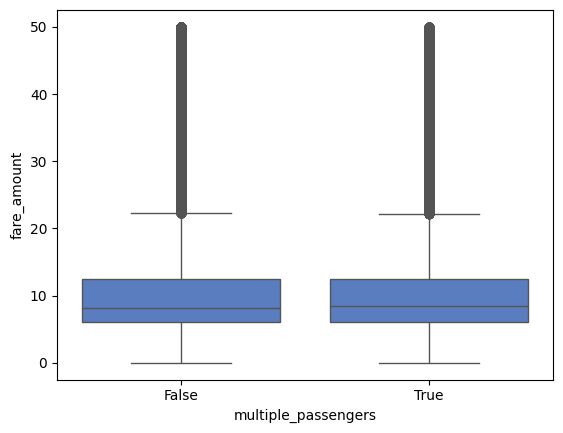

In [238]:
taxi_pass_red = taxi.copy()
taxi_pass_red['multiple_passengers'] = np.where(taxi_pass_red['passenger_count'] > 1, True, False)

sns.boxplot(data=taxi_pass_red.loc[taxi_pass_red['fare_amount'] <= 50], x='multiple_passengers', y='fare_amount')

In [239]:
# sns.lmplot(data=taxi_pass_red.loc[taxi_pass_red['distance_km'] <= 25], x='distance_km', y='fare_amount', hue='multiple_passengers', scatter_kws={'alpha':0.02})

### Fare vs Time

#### Fare vs Pickup Hour

Text(0.5, 1.0, 'Fare vs Hour')

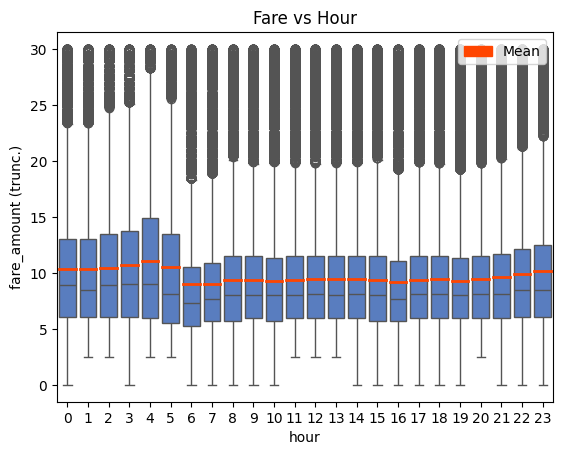

In [240]:
fare_hour_box = sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 30], x='hour', y='fare_amount', showmeans=True, meanline=True, meanprops={'linestyle':'-', 'linewidth':2, 'color':'orangered'})
fare_hour_box.set_ylabel(f'{fare_hour_box.get_ylabel()} (trunc.)')
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')
plt.title('Fare vs Hour')

#### Fare vs Pickup Day of Week

Text(0.5, 1.0, 'Fare vs Day of Week')

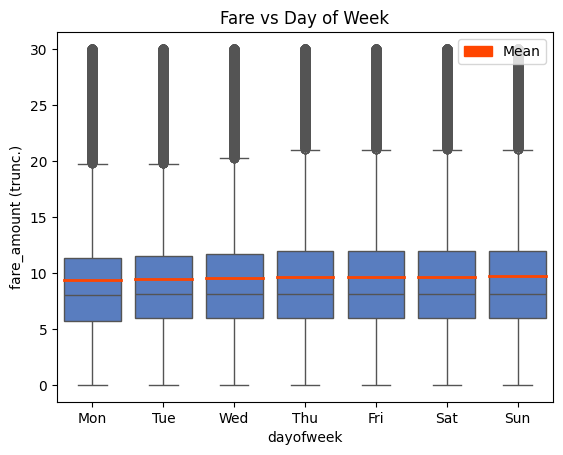

In [241]:
fare_dayofweek_box = sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 30], x='dayofweek', y='fare_amount', order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], showmeans=True, meanline=True, meanprops={'linestyle':'-', 'linewidth':2, 'color':'orangered'})
fare_dayofweek_box.set_ylabel(f'{fare_dayofweek_box.get_ylabel()} (trunc.)')
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')
plt.title('Fare vs Day of Week')

#### Fare vs Pickup Month

Text(0.5, 1.0, 'Fare vs Month')

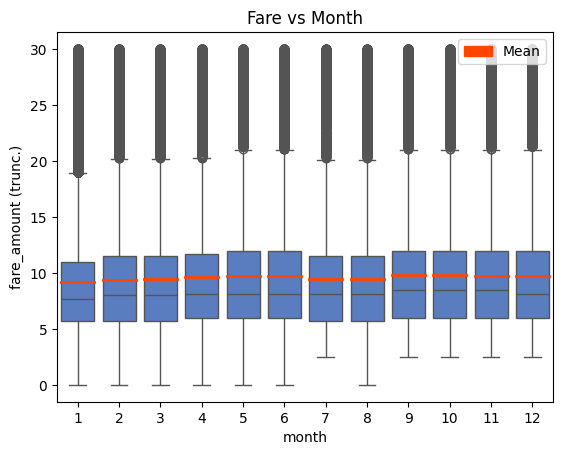

In [242]:
fare_month_box = sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 30], x='month', y='fare_amount', showmeans=True, meanline=True, meanprops={'linestyle':'-', 'linewidth':2, 'color':'orangered'})
fare_month_box.set_ylabel(f'{fare_month_box.get_ylabel()} (trunc.)')
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')
plt.title('Fare vs Month')

#### Fare vs Pickup Year

Text(0.5, 1.0, 'Fare vs Year')

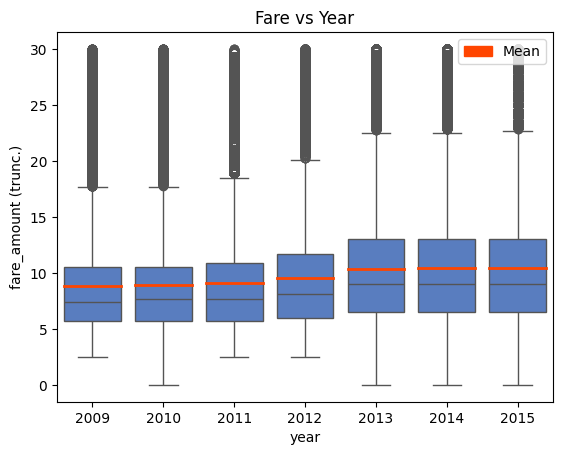

In [243]:
fare_year_box = sns.boxplot(data=taxi.loc[taxi['fare_amount'] <= 30], x='year', y='fare_amount', showmeans=True, meanline=True, meanprops={'linestyle':'-', 'linewidth':2, 'color':'orangered'})
fare_year_box.set_ylabel(f'{fare_year_box.get_ylabel()} (trunc.)')
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')
plt.title('Fare vs Year')

#### Fare vs Pickup Day of Week and Hour

<Axes: xlabel='dayofweek', ylabel='hour'>

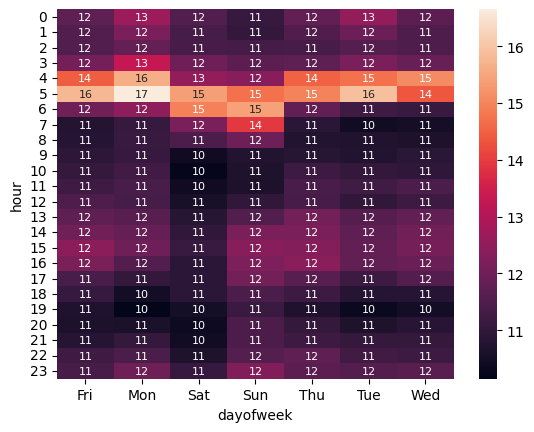

In [244]:
fare_dayofweek_hour = taxi.groupby(['dayofweek', 'hour'])['fare_amount'].mean().reset_index()
fare_dayofweek_hour = fare_dayofweek_hour.pivot(index='hour', columns='dayofweek', values='fare_amount')

sns.heatmap(data=fare_dayofweek_hour, annot=True, annot_kws={'size':8})

### Location

In [245]:
# sns.scatterplot(data=taxi.loc[taxi['fare_amount'] <= 50], x='dropoff_longitude', y='dropoff_latitude', hue='fare_amount', alpha=0.5)

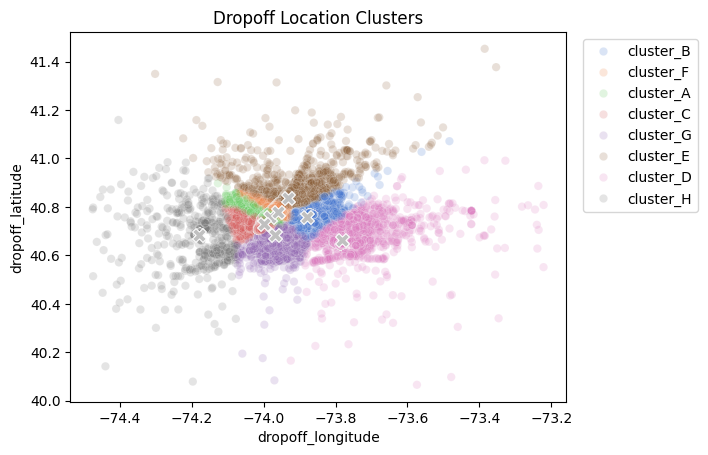

In [246]:
dropoff_locs = taxi[['dropoff_longitude', 'dropoff_latitude']]
# scaler = StandardScaler()
# scaled_dropoff_locs = scaler.fit_transform(dropoff_locs)

kmeans = KMeans(n_clusters=8, n_init=10)
kmeans.fit(dropoff_locs)

clust_name_dict = {i:f'cluster_{c}' for i,c in enumerate(ascii_uppercase)}
kmeans_clusters = pd.Series(kmeans.labels_).replace(clust_name_dict)
kmeans_centroids = pd.DataFrame(kmeans.cluster_centers_).rename(columns={0:'dropoff_longitude', 1:'dropoff_latitude'}, index=clust_name_dict)

sns.scatterplot(data=taxi, x='dropoff_longitude', y='dropoff_latitude', hue=kmeans_clusters, alpha=0.2)
sns.scatterplot(data=kmeans_centroids, x='dropoff_longitude', y='dropoff_latitude', s=100, c='silver', marker='X')
plt.title('Dropoff Location Clusters')
plt.legend(loc='upper right', bbox_to_anchor=(1.28, 1))

In [247]:
kmeans_cluster_fares = pd.DataFrame()
kmeans_cluster_fares['count'] = taxi.groupby(kmeans_clusters)['key'].count()
kmeans_cluster_fares['mean'] = taxi.groupby(kmeans_clusters)['fare_amount'].mean()
kmeans_cluster_fares['mean_diff'] = kmeans_cluster_fares['mean'] - taxi['fare_amount'].mean()
kmeans_cluster_fares['summed_diff'] = kmeans_cluster_fares['count'] * abs(kmeans_cluster_fares['mean_diff'])
print(kmeans_cluster_fares['summed_diff'].sum()/len(taxi))
kmeans_cluster_fares.head(len(kmeans_cluster_fares))

2.7064868378338787


,count,mean,mean_diff,summed_diff
cluster_A,387641,9.700317,-1.630273,631960.602064
cluster_B,29727,23.904141,12.573551,373773.938472
cluster_C,255988,10.081497,-1.249093,319752.885290
cluster_D,10995,40.945087,29.614497,325611.391989
cluster_E,20507,19.905443,8.574853,175844.509078
cluster_F,213043,9.670910,-1.659680,353583.163987
cluster_G,44914,18.847878,7.517288,337631.456815
cluster_H,1754,64.030336,52.699746,92435.354987


### Direction

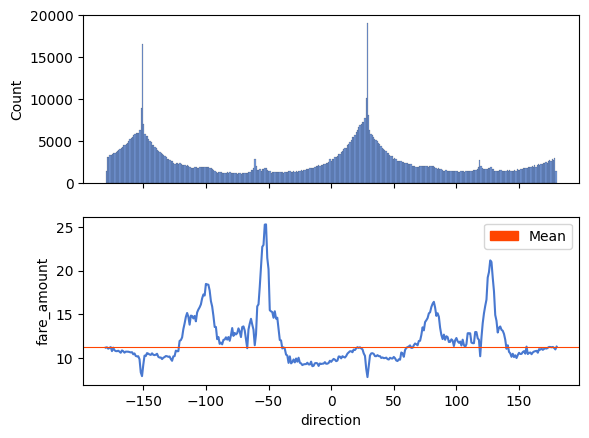

In [248]:
fig, axs = plt.subplots(2, 1, sharex=True)

direction_round = round(taxi['direction'])
sns.histplot(ax=axs[0], data=direction_round, bins=361)

direction_fare_group = taxi.groupby(direction_round)['fare_amount'].mean()
sns.lineplot(ax=axs[1], data=direction_fare_group)
plt.axhline(y=taxi['fare_amount'].mean(), color='orangered', linewidth=0.8)
plt.legend(handles=[mpatches.Patch(color='orangered', label='Mean')], loc='upper right')

## Feature Selection

In [336]:
y = taxi['fare_amount']

num_features = ['distance_km', 'direction', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
cat_features = ['nighttime', 'jfk', 'lga', 'ewr']
cat_ohe_features = ['year', 'pickup_loc', 'dropoff_loc', 'distance_loc']

features_list = num_features + cat_features + cat_ohe_features

X_cat = taxi[features_list]
X = pd.get_dummies(X_cat, columns=cat_ohe_features)
cat_labels = [f for f in X if f.startswith(tuple(cat_features + cat_ohe_features))]

## Modelling

In [250]:
test_size_vals = [0.01, 0.1, 0.2]
results_dict = {}

repeats = 10
aggr_RMSE_list = [0 for _ in range(repeats)]

# model = LinearRegression()
model = HistGradientBoostingRegressor(max_leaf_nodes=20, categorical_features=cat_labels)
for test_size_val in test_size_vals:
    for repeat in range(repeats):
        train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=test_size_val, random_state=repeat)
        model.fit(train_X, train_y)
        pred_y = model.predict(val_X)
        aggr_RMSE_list[repeat] = mean_squared_error(val_y, pred_y, squared=False)
    aggr_RMSE = (sum(aggr_RMSE_list)/repeats)
    results_dict[test_size_val] = round(aggr_RMSE, 4)

results = pd.Series(results_dict)
print(f"Mean RMSE: {results.mean():.4f}")
print(results)

Mean RMSE: 3.4909
0.01    3.4598
0.10    3.4968
0.20    3.5160
dtype: float64


In [254]:
# model = HistGradientBoostingRegressor(categorical_features=cat_labels)
# params ={'max_iter':[100, 150, 200], 'max_leaf_nodes':[31, 20, 25], 'max_depth':[None, 8, 10, 12]}
# gs_cv = GridSearchCV(model, params, verbose=1)
# gs_cv.fit(X, y)
# pd.DataFrame(gs_cv.cv_results_).sort_values(by='rank_test_score')

## Final Model and Predictions

In [ ]:
model = HistGradientBoostingRegressor(max_leaf_nodes=20, categorical_features=cat_labels, random_state=2)
model.fit(X, y)

In [ ]:
test = pd.read_csv('test.csv')

test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])
test['distance_km'] = distance_km(test)
test['hour'] = hour(test)
test['dayofweek'] = dayofweek(test)
test['month'] = month(test)
test['year'] = year(test)
test['nighttime'] = nighttime(test)
test['multiple_passengers'] = multiple_passengers(test)
test['pickup_loc'] = pickup_loc(test)
test['dropoff_loc'] = dropoff_loc(test)
test['distance_loc'] = distance_loc(test)
test['jfk'] = jfk(test)
test['lga'] = lga(test)
test['ewr'] = ewr(test)
test['direction'] = direction(test)

In [ ]:
test_X_cat = test[features_list]
test_X = pd.get_dummies(test_X_cat, columns=cat_ohe_features)

test_preds = model.predict(test_X)

## Submission

In [ ]:
output = pd.DataFrame({'key': test['key'], 'fare_amount': test_preds})
output.to_csv('submission.csv', index=False)